In [1]:
import sys 
sys.path.append('../..')

import jax
from functools import partial
from jax import grad, jacfwd, vmap, jit, hessian, value_and_grad
from jax.lax import scan
# from jax.ops import index_update, index
import jax.random as jnp_random
import jax.numpy as np

from jax.flatten_util import ravel_pytree

import numpy as onp
from time_opt_erg_lib.dynamics import DoubleIntegrator, SingleIntegrator, ThreeDAirCraftModel

from time_opt_erg_lib.ergodic_metric import ErgodicMetric
from time_opt_erg_lib.obstacle import Obstacle
from time_opt_erg_lib.cbf import constr2CBF
from time_opt_erg_lib.fourier_utils import BasisFunc, get_phik, get_ck
from time_opt_erg_lib.target_distribution import TargetDistribution
from time_opt_erg_lib.cbf_utils import sdf3cbf
from IPython.display import clear_output
import matplotlib.pyplot as plt

from time_opt_erg_lib.opt_solver import AugmentedLagrangeSolver
import yaml
import pickle as pkl

In [2]:
class TargetDistribution(object):
    def __init__(self) -> None:
        self.n = 3
        self.domain = np.meshgrid(
            *[np.linspace(0,1)]*self.n
        )
        self._s = np.stack([X.ravel() for X in self.domain]).T
        self.evals = (
            vmap(self.p)(self._s) , self._s
        )
        # def plot(self):
        #     plt.contour(self.domain[0], self.domain[1], self.evals[0].reshape(self.domain[0].shape))

    def p(self, x):
        return 1.0

In [17]:
basis           = BasisFunc(n_basis=[8,8,8])
erg_metric      = ErgodicMetric(basis)
robot_model     = ThreeDAirCraftModel()
n,m = robot_model.n, robot_model.m
target_distr    = TargetDistribution()


args = {
    'N' : 400, 
    'x0' : np.array([0.1, 0.12, 0.1, 0., 0.]),
    'xf' : np.array([2.5, 9.0, 2.5, 0., 0.]),
    'erg_ub' : 0.005,
    'alpha' : 0.2,
    'wrksp_bnds' : np.array([[0.,5],[0.,10],[0.,5.]])
}

# with open('../../config/cluttered_env.yml', 'r') as file:
#     obs_info = yaml.safe_load(file)
_key = jnp_random.PRNGKey(0)


_N_obs = 10
obs = []
cbf_constr = []
for i in range(_N_obs):
    _key, _subkey = jnp_random.split(_key)
    _pos = jnp_random.uniform(_subkey, shape=(3,), 
                       minval=np.array([0,0,0]), maxval=np.array([0,10,5]))
    _key, _subkey = jnp_random.split(_key)
    _rad = jnp_random.uniform(_subkey, shape=(3,), minval=0.15, maxval=.5) 
    _ob_inf = {
        'pos' : _pos, 
        'half_dims' : _rad,
        'rot': 0.
    }
    _ob = Obstacle(_ob_inf, p=2)
        # pos=np.array(obs_info[obs_name]['pos']), 
        # half_dims=np.array(obs_info[obs_name]['half_dims']),
        # th=obs_info[obs_name]['rot']
    obs.append(_ob)
    cbf_constr.append(sdf3cbf(robot_model.dfdt, _ob.distance3))

args.update({
    'phik' : get_phik(target_distr.evals, basis),
})

## <--- I DO NOT LIKE THIS
workspace_bnds = args['wrksp_bnds']

# opt_args = {
#     'N' : 100, 
#     'x0' : np.array([0.1, 0.1, 0., 0.]),
#     'xf' : np.array([0.9, 0.9, 0., 0.]),
#     'phik' : get_phik(target_distr.evals, basis),
#     'erg_ub' : 0.1,
#     # 'alpha' : 0.8,
# }

@vmap
def emap(x):
    """ Function that maps states to workspace """
    return np.array([
        (x[0]-workspace_bnds[0][0])/(workspace_bnds[0][1]-workspace_bnds[0][0]), 
        (x[1]-workspace_bnds[1][0])/(workspace_bnds[1][1]-workspace_bnds[1][0]),
        (x[2]-workspace_bnds[2][0])/(workspace_bnds[2][1]-workspace_bnds[2][0])        
        ])
        
def barrier_cost(e):
    """ Barrier function to avoid robot going out of workspace """
    return (np.maximum(0, e-1) + np.maximum(0, -e))**2

# @jit
def loss(params, args):
    x = params['x']
    u = params['u']
    tf = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    """ Traj opt loss function, not the same as erg metric """
    return np.sum(barrier_cost(e)) + tf

def eq_constr(params, args):
    """ dynamic equality constriants """
    x = params['x']
    u = params['u']

    x0 = args['x0']
    xf = args['xf']
    tf = params['tf']
    N  = args['N']
    dt = tf/N
    return np.vstack([
        x[0] - x0, 
        x[1:,:]-(x[:-1,:]+dt*vmap(robot_model.dfdt)(x[:-1,:], u[:-1,:])),
        x[-1] - xf
    ])

def ineq_constr(params, args):
    """ inequality constraints"""
    x       = params['x']
    u       = params['u']
    phik    = args['phik']
    tf      = params['tf']
    N = args['N']
    dt = tf/N
    e = emap(x)
    _cbf_ineq = [vmap(_cbf_ineq, in_axes=(0,0,None, None))(x, u, args['alpha'], dt).flatten() 
                for _cbf_ineq in cbf_constr]
    ck = get_ck(e, basis, tf, dt)
    _erg_ineq = [np.array([erg_metric(ck, phik) - args['erg_ub'], -tf])]
    _ctrl_box = [(-u[:,0]+.5).flatten(), (u[:,0]-5.0).flatten(), (np.abs(u[:,1:]) - np.pi/3).flatten()]
    return np.concatenate(_erg_ineq + _ctrl_box + _cbf_ineq)


x = np.linspace(args['x0'], args['xf'], args['N'], endpoint=True)
u = np.zeros((args['N'], robot_model.m))
init_sol = {'x': x, 'u' : u, 'tf': np.array(25.0)}
solver = AugmentedLagrangeSolver(
                init_sol,
                loss, 
                eq_constr, 
                ineq_constr, 
                args, 
                step_size=0.0005,
                c=1.0)

In [18]:
solver.solve(max_iter=10000, eps=1e-7)
sol = solver.get_solution()


done in  8821  iterations


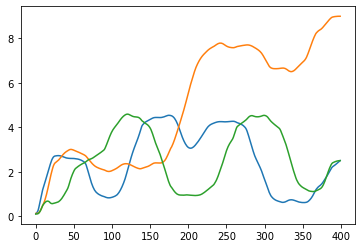

In [19]:
plt.plot(sol['x'][:,:3])

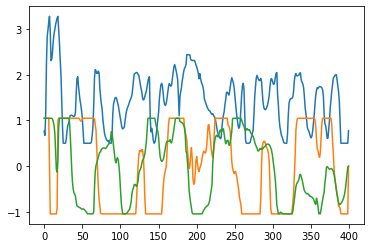

In [20]:
plt.plot(sol['u'])

In [21]:
sol['tf']

DeviceArray(24.445723, dtype=float32, weak_type=True)

In [8]:



## <---- below draws the objects ---->
# for obs in traj_opt.obs:
#     _patch = obs.draw()
#     plt.gca().add_patch(_patch)

X, Y = np.meshgrid(*[np.linspace(wks[0],wks[1]) for wks in args['wrksp_bnds']])
pnts = np.vstack([X.ravel(), Y.ravel()]).T

_mixed_vals = np.inf * np.ones_like(X)
for ob in obs:
    _vals = np.array([ob.distance(pnt) for pnt in pnts]).reshape(X.shape)
    _mixed_vals = np.minimum(_vals, _mixed_vals)

    plt.contour(X, Y, _vals.reshape(X.shape), levels=[-0.01,0.,0.01])

plt.plot(sol['x'][:,0], sol['x'][:,1],'g.')
plt.plot(sol['x'][:,0], sol['x'][:,1])

# sol.update({
#     'x' : np.array(sol['x']),
#     'u' : np.array(sol['u']),
#     'tf': np.array(sol['tf'])
# })

# _file = open('test_traj_max_erg_002.pkl', 'wb')
# pkl.dump(sol, _file)

plt.show()

ValueError: too many values to unpack (expected 2)

In [22]:
solver.ineq_constr(sol, args)

DeviceArray([ 1.1238734e-02, -2.4445723e+01, -2.6177567e-01, ...,
             -4.4182167e+00, -4.4216347e+00, -4.4356594e+00],            dtype=float32)